In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Resources


In [56]:
DATASET = 'data/audio_dataset.csv'
AUDIO_FEATURES = 'data/audio_features.csv'


# Prepare data
## Load data

In [59]:
dataset_df = pd.read_csv(DATASET)

In [154]:
features_df = pd.read_csv(AUDIO_FEATURES)

# add revenue information
merged = features_df.merge(
    dataset_df[['imdb_id', 'revenue_opening']].drop_duplicates('imdb_id'), on='imdb_id'
)
merged.rename({'revenue_opening' : 'revenue'}, inplace=True)

df_unnorm = features_df.drop('imdb_id', axis=1)

df_norm = df_unnorm.copy().drop(['mfcc_1_mean', 'beat', 'beat_confidence'], axis=1)
# df_norm = df_norm.subtract(df_unnorm.mean())
# df_norm = df_norm.divide(df_norm.std())


X = df_norm.values

X.shape

(7887, 67)

# Dimensionality reduction

## Data exploration


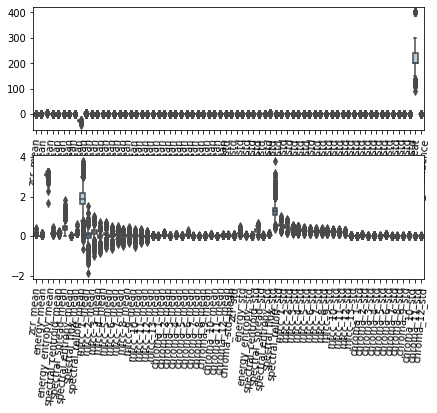

In [155]:
fig, ax = plt.subplots(2, 1, figsize=(7,5))

blp = sns.boxplot(data=df_unnorm,orient='v', palette=sns.color_palette("Blues", 2), ax=ax[0])
ax[0].set_xticklabels(bpl.get_xticklabels(), rotation = 85)

blp = sns.boxplot(data=df_norm,orient='v', palette=sns.color_palette("Blues", 2), ax=ax[1])
ax[1].set_xticklabels(bpl.get_xticklabels(), rotation = 85)

plt.show()

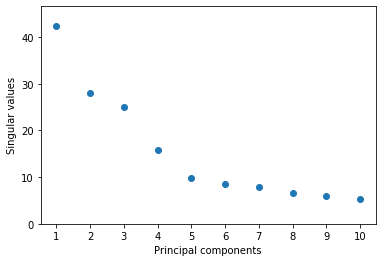

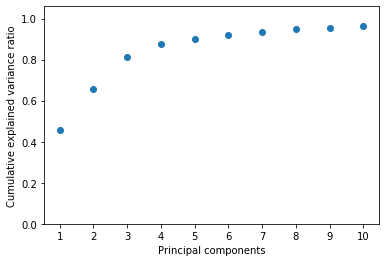

10
Explained variance for 1 components: 0.45567395620683143
Explained variance for 2 components: 0.6553701685064385
Explained variance for 3 components: 0.8135484373535052
Explained variance for 4 components: 0.8772705584469271
Explained variance for 5 components: 0.9016143570230744
Explained variance for 6 components: 0.9197074525039368
Explained variance for 7 components: 0.935317910742265
Explained variance for 8 components: 0.9466340252288296
Explained variance for 9 components: 0.9558054191201413
Explained variance for 10 components: 0.9629916488212164


In [165]:
def generate_pca_plots(pca_model: PCA, n_components=None):
    if n_components is None:
        n_components = len(pca_model.singular_values_)
    x_ticks = np.arange(n_components) + 1

    def generate_plot(y_values, y_label):
        plt.figure()
        plt.scatter(x_ticks, y_values)
        plt.xticks(x_ticks)
        plt.ylim(0, 1.1 * y_values.max())
        plt.xlabel('Principal components')
        plt.ylabel(y_label)
        plt.show()

    generate_plot(pca_model.singular_values_[:n_components], 'Singular values')
    generate_plot(pca_model.explained_variance_ratio_.cumsum()[:n_components], 'Cumulative explained variance ratio')
    
pca = PCA(10)
pca.fit(X)
generate_pca_plots(pca)
print(len(pca.singular_values_))

for i in range(len(pca.singular_values_)):
    print(f'Explained variance for {i+1} components: {pca.explained_variance_ratio_.cumsum()[i]}')
    

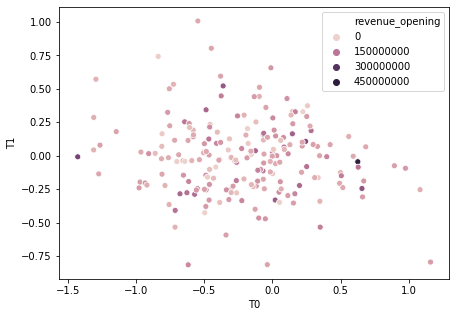

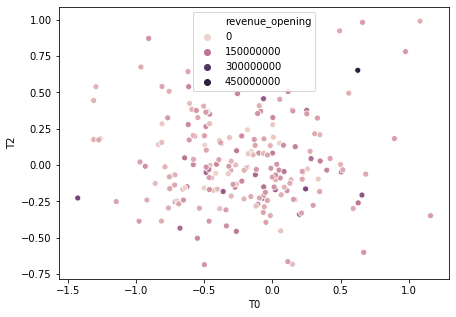

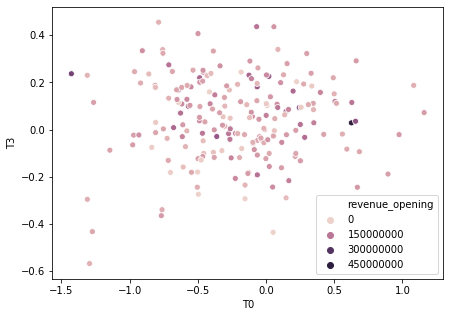

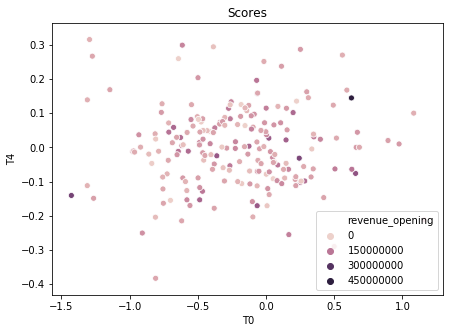

In [167]:
pca = PCA(5)
T = pca.fit_transform(X)

fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x = T[:200,0],y = T[:200,1], hue = merged['revenue_opening'].head(200))
plt.xlabel('T0')
plt.ylabel('T1')

fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x = T[:200,0],y = T[:200,2], hue = merged['revenue_opening'].head(200))
plt.xlabel('T0')
plt.ylabel('T2')

fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x = T[:200,0],y = T[:200,3], hue = merged['revenue_opening'].head(200))
plt.xlabel('T0')
plt.ylabel('T3')

fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x = T[:200,0],y = T[:200,4], hue = merged['revenue_opening'].head(200))
plt.xlabel('T0')
plt.ylabel('T4')

plt.title('Scores')
plt.show()


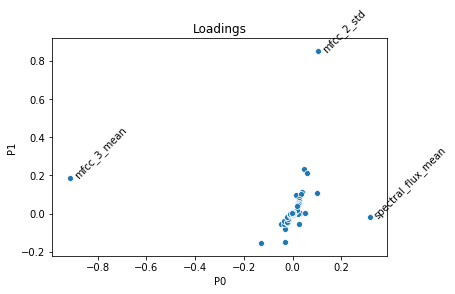

In [168]:
P = pca.components_.T

ax = sns.scatterplot(x=P[:,0], y=P[:,1])
plt.title('Loadings')
plt.xlabel('P0')
plt.ylabel('P1')
for kk,nme in enumerate(df_norm.columns[1:]):
    if nme in ['mfcc_3_mean', 'mfcc_2_std', 'spectral_flux_mean']:
        ax.annotate(nme,(P[kk,0]+.01,P[kk,1]), rotation=45)

## Final model


In [160]:
dim_red_model = Pipeline([('scale', StandardScaler()), ('pca', PCA(5))])


### Report error on test data


In [173]:
mse = 0
for i in range(20):
    x_train, x_test = train_test_split(X, test_size=.2)

    dim_red_model.fit(x_train)
    predicions = dim_red_model.inverse_transform(dim_red_model.transform(x_test))
    curr_mse = predicions - x_test
    curr_mse **= 2
    mse += curr_mse.sum()
    
print(f"MSE = {mse / 20}")

MSE = 230.77652371937637


### Reduce dimension

In [174]:
dim_red_model.fit(X)
reduced_X = dim_red_model.transform(X)
print(reduced_X.shape)


(7887, 5)


### Save new data and the model


In [175]:
with open('feats_dimred.model', 'wb') as fw:
    pickle.dump(dim_red_model, fw)


### Test saved model


In [176]:
with open('feats_dimred.model', 'rb') as fr:
    loaded_model = pickle.load(fr)

assert(np.all(reduced_X == loaded_model.transform(X)))


Beat and mfcc_1_mean will be added to the audio pipeline output as an independent features.
